In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import csv
import random
import math
from shapely.geometry import Polygon
from itertools import compress
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D,Input,UpSampling2D,BatchNormalization,Concatenate,Input,Activation,concatenate,add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# preparing data

### code is taken from-- https://github.com/Pay20Y/FOTS_TF/tree/dev

## preparing data for detection

IN  this section we will extract score map, geomap , angle of rotation from given image and text data. So after recieving these data we can pass our image to detection algo and it can minimize the loss between it's predicted score map and actual score map and like that for geomap and rotation angle also.

### calculating polygon area

In [3]:
def polygon_area(poly):
    '''
    compute area of a polygon
    :param poly:
    :return:
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

### checking and validating polys

In [4]:
def check_and_validate_polys(polys, tags, labels, xxx_todo_changeme):
    '''
    check so that the text poly is in the same direction,
    and also filter some invalid polygons
    :param polys:
    :param tags:
    :return:
    '''
    (h, w) = xxx_todo_changeme
    
    validated_polys = []
    validated_tags = []
    validated_labels = []

    if polys.shape[0] == 0:
        # return polys
        return np.array(validated_polys), np.array(validated_tags)
    #print(polys)
    #print(np.clip(polys[:, :, 0], 0, w-1))
    # clipping polys x and y to w-1 and h-1 value if there value is greater than width of image or height of the image
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)
    #print(polys[:, :, 0])

    
    for poly, tag, label in zip(polys, tags, labels):
        p_area = polygon_area(poly)
        #print(poly)
        if abs(p_area) < 1:
            # print poly
            # print('invalid poly')
            continue
#         plt.plot(poly[:, 0], poly[:, 1])
#         print(p_area)
#         plt.show() 
        if p_area > 0:
            #print('poly in wrong direction')
            
            poly = poly[(0, 3, 2, 1), :]

        if not check_is_horizon(poly):
            # print("vertical text area")
            continue
        validated_polys.append(poly)
        validated_tags.append(tag)
        validated_labels.append(label)

    return np.array(validated_polys), np.array(validated_tags), validated_labels

In [5]:
def check_is_horizon(poly):
	"""
	Since FOTS can not deal with vertical text area
	so we check it
	"""
	edge1 = norm2(poly[0] - poly[1])
	edge2 = norm2(poly[1] - poly[2])
	edge3 = norm2(poly[2] - poly[3])
	edge4 = norm2(poly[3] - poly[0])

	if (4.0 * (edge1 + edge3) / 2.0) < ((edge2 + edge4) / 2.0):
		return False
	else:
		return True

	return True

In [6]:
def norm2(x, axis=None):
	if axis:
		return np.sqrt(np.sum(x ** 2, axis=axis))
	return np.sqrt(np.sum(x ** 2)) 

### rotating image with some random angle

In [7]:
def rotate_image(img, boxes, angle, scale=1):
    #print(img.shape)
    H, W, _ = img.shape
    rangle = np.deg2rad(angle)  # angle in radians
    new_width = (abs(np.sin(rangle) * H) + abs(np.cos(rangle) * W)) * scale
    new_height = (abs(np.cos(rangle)*H) + abs(np.sin(rangle)*W))*scale

    rot_mat = cv2.getRotationMatrix2D((new_width * 0.5, new_height * 0.5), angle, scale)
    # print(rot_mat)
    rot_move = np.dot(rot_mat, np.array([(new_width - W) * 0.5, (new_height - H) * 0.5, 0]))
    # print(rot_move)
    # print(rot_mat[0, 2])
    rot_mat[0, 2] += rot_move[0]
    rot_mat[1, 2] += rot_move[1]

    rot_img = cv2.warpAffine(img, rot_mat, (int(math.ceil(new_width)), int(math.ceil(new_height))), flags=cv2.INTER_LANCZOS4)

    rot_bboxes = list()
    for bbox in boxes:
        new_box = []
        for point in bbox:
            r_point = np.dot(rot_mat, np.array([point[0], point[1], 1]))
            new_box.append(r_point)
        rot_bboxes.append(new_box)
        # point1 = np.dot(rot_mat, np.array([(xmin + xmax) / 2, ymin, 1]))
    return rot_img, np.array(rot_bboxes)

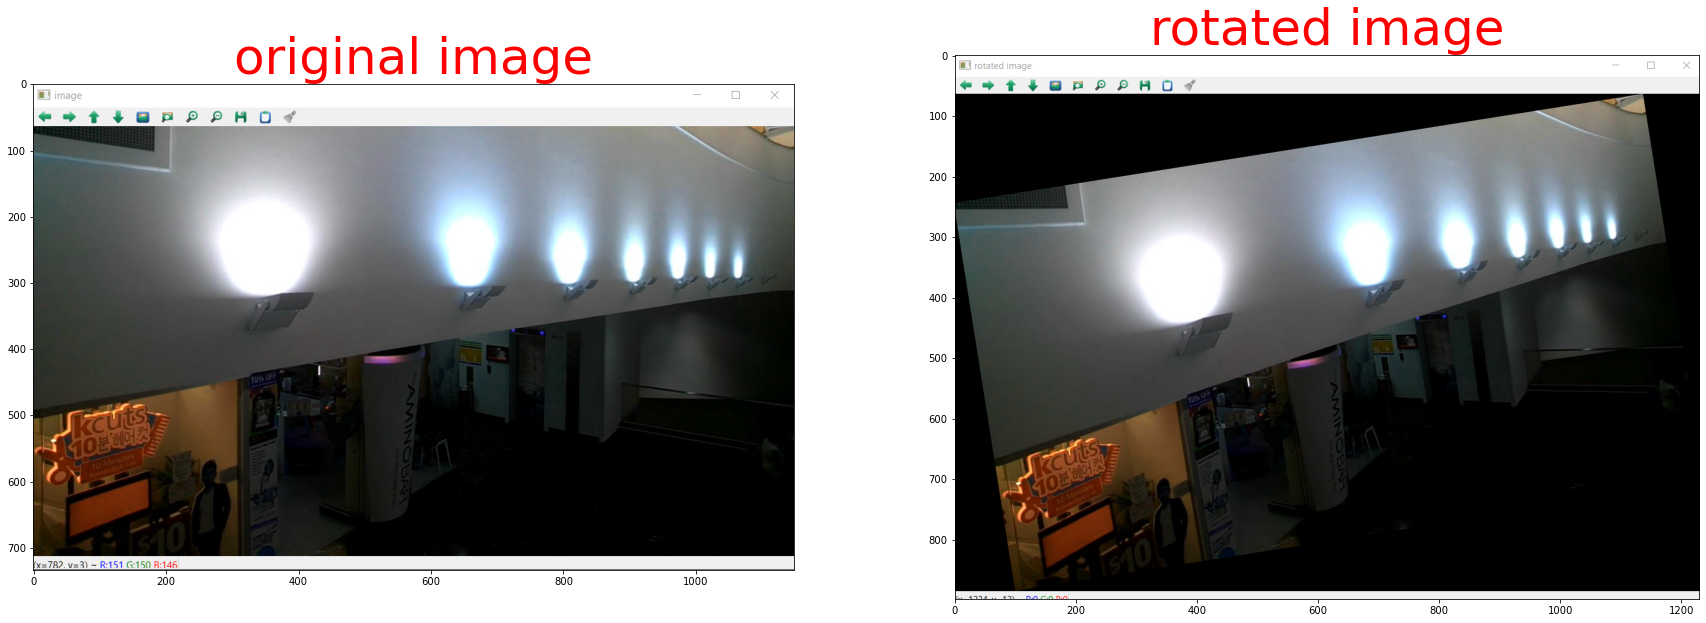

In [8]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
image=cv2.imread('documentation_images/Screenshot (337).png')
plt.imshow(image)

plt.title('original image',color='red',size=50)


# Plot training & validation loss values
plt.subplot(122)
image=cv2.imread('documentation_images/Screenshot (338).png')
plt.imshow(image)

plt.title('rotated image',color='red',size=50)

plt.show()

In [8]:
def crop_area(im, polys, tags, crop_background = False, max_tries = 50):
    '''
    Copy from github repro FOTS.Pytorch
    make random crop from the input image
    :param im:
    :param polys:
    :param tags:
    :param crop_background:
    :param max_tries:
    :return:
    '''
    # print(im.shape)
    h, w, _ = im.shape
    pad_h = h // 10
    pad_w = w // 10
    h_array = np.zeros((h + pad_h * 2), dtype = np.int32)
    w_array = np.zeros((w + pad_w * 2), dtype = np.int32)
    for poly in polys:
        #print(poly)
        poly = np.round(poly, decimals = 0).astype(np.int32)
        #print(poly)
        minx = np.min(poly[:, 0])
        #print(minx)
        maxx = np.max(poly[:, 0])
        # print(w_array[minx + pad_w:maxx + pad_w])
        w_array[minx + pad_w:maxx + pad_w] = 1
        miny = np.min(poly[:, 1])
        maxy = np.max(poly[:, 1])
        h_array[miny + pad_h:maxy + pad_h] = 1
    # ensure the cropped area not across a text

    h_axis = np.where(h_array == 0)[0]
    # print(h_array)
    # print(h_axis)
    w_axis = np.where(w_array == 0)[0]
    if len(h_axis) == 0 or len(w_axis) == 0:
        return im, polys, tags, np.array(len(polys))
    for i in range(max_tries):
        xx = np.random.choice(w_axis, size = 2)
        # print(xx)
        xmin = np.min(xx) - pad_w
        xmax = np.max(xx) - pad_w
        xmin = np.clip(xmin, 0, w - 1)
        xmax = np.clip(xmax, 0, w - 1)
        yy = np.random.choice(h_axis, size = 2)
        ymin = np.min(yy) - pad_h
        ymax = np.max(yy) - pad_h
        ymin = np.clip(ymin, 0, h - 1)
        ymax = np.clip(ymax, 0, h - 1)
        # if xmax - xmin < FLAGS.min_crop_side_ratio*w or ymax - ymin < FLAGS.min_crop_side_ratio*h:
        if xmax - xmin < 0.1 * w or ymax - ymin < 0.1 * h:
            # area too small
            continue
        if polys.shape[0] != 0:
            # print(polys)
            # print(polys[:, :, 0])
            poly_axis_in_area = (polys[:, :, 0] >= xmin) & (polys[:, :, 0] <= xmax) \
                                & (polys[:, :, 1] >= ymin) & (polys[:, :, 1] <= ymax)
            # print(poly_axis_in_area)
            selected_polys = np.where(np.sum(poly_axis_in_area, axis = 1) == 4)[0]
        else:
            selected_polys = []
        if len(selected_polys) == 0:
            # no text in this area
            if crop_background:
                return im[ymin:ymax + 1, xmin:xmax + 1, :], polys[selected_polys], tags[selected_polys], selected_polys
            else:
                continue
        im = im[ymin:ymax + 1, xmin:xmax + 1, :]
        polys = polys[selected_polys]
        tags = tags[selected_polys]
        polys[:, :, 0] -= xmin
        polys[:, :, 1] -= ymin
        return im, polys, tags, selected_polys

    return im, polys, tags, np.array(range(len(polys)))

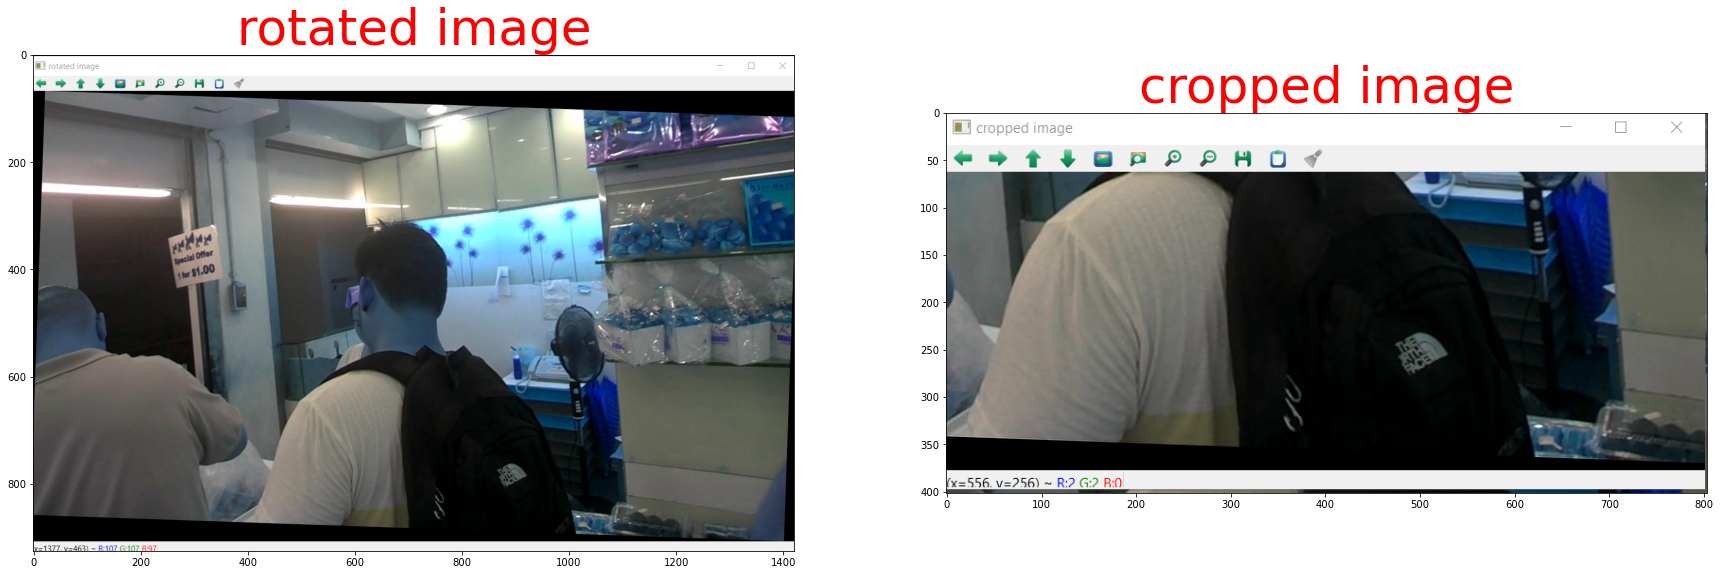

In [10]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
image=cv2.imread('documentation_images/Screenshot (345).png')
plt.imshow(image)

plt.title('rotated image',color='red',size=50)


# Plot training & validation loss values
plt.subplot(122)
image=cv2.imread('documentation_images/Screenshot (346).png')
plt.imshow(image)

plt.title('cropped image',color='red',size=50)

plt.show()

In [9]:
def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly, maybe bugs here...
    used for generate the score map
    :param poly: the text poly
    :param r: r in the paper
    :return: the shrinked poly
    '''
    # shrink ratio
    R = 0
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        #print('===================================')
        #print(poly[1]-poly[0])
        #print((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        #print('====================================')
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly

### we can see here how image poly is shrinking with the help of one image polygons

iter:  0


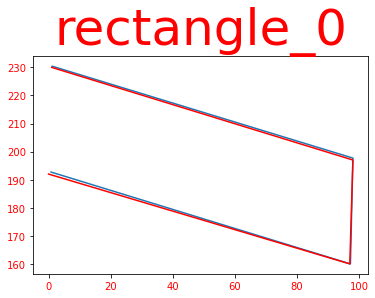

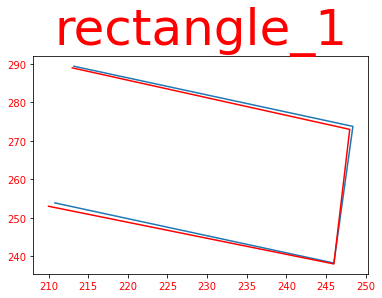

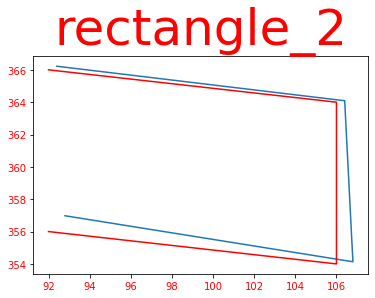

In [29]:
test()

In [10]:
def fit_line(p1, p2):
    # fit a line ax+by+c = 0
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        #print([k, b])
        return [k, -1., b]

In [11]:
def point_dist_to_line(p1, p2, p3):
    # compute the distance from p3 to p1-p2
    # print(p1,p2,p3)
    try:
        return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
    except:
        print(p1,p2,p3)
        return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)


In [12]:
def line_cross_point(line1, line2):
    # line1 0= ax+by+c, compute the cross point of line1 and line2
    if line1[0] != 0 and line1[0] == line2[0]:
        #print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        #print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

In [13]:
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    :param poly:
    :return:
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

In [14]:
def line_verticle(line, point):
    # get the verticle line from line across point
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

In [15]:
def sort_rectangle(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # 底边平行于X轴, 那么p0为左上角 - if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # 找到最低点右边的点 - find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # 这个点为p2 - this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # 这个点为p3 - this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [27]:
def generate_rbox(im_size, polys, tags):
    #print(im_size)
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    rectangles = []
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        tag = poly_tag[1]
        # print(tag)

        r = [None, None, None, None]
        for i in range(4):
            #print('-------------')
            #print(poly)
            #print(poly[i] - poly[(i + 1) % 4])
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))

        #print(r)

        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        # print(shrinked_poly)
        
        plt.plot(poly[:, 0], poly[:, 1])
        plt.plot(shrinked_poly[0][:, 0], shrinked_poly[0][:, 1], color='red')
        plt.title('rectangle_'+str(poly_idx),color='red',size=50)
        plt.xticks(color='red')
        plt.yticks(color='red')
        plt.show()


        cv2.fillPoly(score_map, shrinked_poly, 1)
        # cv2.imshow("Resized imagsm", score_map)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)
        # cv2.imshow("Resized imagpm", poly_mask)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(poly[0] - poly[3]), np.linalg.norm(poly[1] - poly[2]))
        poly_w = min(np.linalg.norm(poly[0] - poly[1]), np.linalg.norm(poly[2] - poly[3]))
        # print('==============',poly.astype(np.int32)[np.newaxis, :, :])
        if min(poly_h, poly_w) < 6:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        if tag:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)

        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        #print('+++++++++++++++++++++++++++',xy_in_poly)
        # if geometry == 'RBOX':
        # 对任意两个顶点的组合生成一个平行四边形 - generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]]) # [k1, -1, b]

            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            # print(backward_edge)


            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                # 平行线经过p2 - parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # 经过p3 - after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            # print(type(new_p2))
            if type(new_p2)!=np.ndarray:
                if new_p2==None:
                    return None, None, None, None
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            
            # plt.plot(np.array([new_p0, new_p1, new_p2, new_p3, new_p0])[:, 0], np.array([new_p0, new_p1, new_p2, new_p3, new_p0])[:, 1], color='green')
            # plt.plot([0,(poly[1]-poly[0])[0]],[0,(poly[1]-poly[0])[1]])
            # plt.show()

        #print('000000000000000000000000000000000000000000000',fitted_parallelograms)
#         if len(fitted_parallelograms)!=4:
#             break

        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)
        rectangles.append(rectange.flatten())
        p0_rect, p1_rect, p2_rect, p3_rect = rectange
        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point)
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point)
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point)
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point)
            # angle
            geo_map[y, x, 4] = rotate_angle
#         cv2.imshow("Resized imagpm", geo_map[:,:,1])
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

    return score_map, geo_map, training_mask, rectangles

In [20]:
def get_project_matrix_and_width(text_polyses, text_tags, target_height=8.0):
    project_matrixes = []
    box_widths = []

    for i in range(text_polyses.shape[0]):
        x1, y1, x2, y2, x3, y3, x4, y4 = text_polyses[i] / 4
        # x1, y1, x2, y2, x3, y3, x4, y4 = text_polyses[i]

        rotated_rect = cv2.minAreaRect(np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]))
        box_w, box_h = rotated_rect[1][0], rotated_rect[1][1]

        if box_w <= box_h:
            box_w, box_h = box_h, box_w

        mapped_x1, mapped_y1 = (0, 0)
        mapped_x4, mapped_y4 = (0, 8)

        width_box = math.ceil(8 * box_w / box_h)
        width_box = int(min(width_box, 128)) # not to exceed feature map's width
        mapped_x2, mapped_y2 = (width_box, 0)
        src_pts = np.float32([(x1, y1), (x2, y2), (x4, y4)])
        dst_pts = np.float32([(mapped_x1, mapped_y1), (mapped_x2, mapped_y2), (mapped_x4, mapped_y4)])
        # project_matrix = cv2.getPerspectiveTransform(dst_pts.astype(np.float32), src_pts.astype(np.float32))
        # project_matrix = project_matrix.flatten()[:8]
        affine_matrix = cv2.getAffineTransform(dst_pts.astype(np.float32), src_pts.astype(np.float32))
        affine_matrix = affine_matrix.flatten()
        project_matrixes.append(affine_matrix)
        box_widths.append(width_box)

    project_matrixes = np.array(project_matrixes)
    box_widths = np.array(box_widths)

    return project_matrixes, box_widths

In [21]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """
        Inspired (copied) from https://github.com/igormq/ctc_tensorflow_example/blob/master/utils.py
    """

    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), [i for i in range(len(seq))]))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

In [22]:
a=np.array([1,2,3])
type(a)

numpy.ndarray

In [22]:
## code is taken from 

def generator(input_images_dir, input_gt_dir, input_size=512, batch_size=12, random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2]),):
    # data_loader = SynthTextLoader()
    # data_loader = ICDARLoader(edition='13', shuffle=True)
    # image_list = np.array(data_loader.get_images(FLAGS.training_data_dir))
    #print(input_images_dir)
#     input_images_dir=input_images_dir.decode('utf-8')
#     input_gt_dir=str(input_gt_dir)
    #print(input_images_dir)
    
    image_list = np.array([i for i in os.listdir(input_images_dir)])
    # print('{} training images in {} '.format(image_list.shape[0], FLAGS.training_data_dir))
    index = np.arange(0, image_list.shape[0])
    # while True:
    np.random.shuffle(index)
    batch_images = []
    batch_image_fns = []
    batch_score_maps = []
    batch_geo_maps = []
    batch_training_masks = []

    batch_text_polyses = []
    batch_text_tagses = []
    batch_boxes_masks = []

    batch_text_labels = []
    count = 0
    for i in index:
        # try:
        im_fn = image_list[i]
        # print(im_fn)
        # if im_fn.split(".")[0][-1] == '0' or im_fn.split(".")[0][-1] == '2':
        #     continue
        #print(os.path.join(input_images_dir, im_fn))
        im = cv2.imread(os.path.join(input_images_dir, im_fn),cv2.IMREAD_UNCHANGED)
        h, w, _ = im.shape
        #print('h, w, _ = im.shape',h, w, _)
        file_name = "gt_" + im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt').split('/')[-1]
        # print(file_name)
        # file_name = im_fn.replace(im_fn.split('.')[1], 'txt') # using for synthtext
        # txt_fn = os.path.join(FLAGS.training_gt_data_dir, file_name)
        txt_fn = os.path.join(input_gt_dir, file_name)
        if not os.path.exists(txt_fn):
            #print('text file {} does not exists'.format(txt_fn))
            continue
        #print(txt_fn)
        text_polys=[]
        text_tags=[]
        text_labels=[]
        with open(txt_fn, 'r') as f:
            reader = csv.reader(f)
            for line in reader:

                text_labels.append(line[-1])
                if line[-1]=='*' or line[-1]=='###':
                    text_tags.append(True)
                else:
                    text_tags.append(False)
                line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
                text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
#         text_polys, text_tags, text_labels=load_annotation(txt_fn) # Change for load text transiption

        text_polys = np.array(text_polys, dtype=np.float32)
        text_tags = np.array(text_tags, dtype=np.bool)
        text_labels = np.array(text_labels,dtype=np.object)
#         print(text_polys)
        # print(text_tags)
        # print(text_labels)
        if text_polys.shape[0] == 0:
            continue
        #print('text_polys.shape',text_polys.shape)
        #print('text_tags.shape',text_tags.shape)
        #print('text_labels.shape',text_labels.shape)
        text_polys, text_tags, text_labels = check_and_validate_polys(text_polys, text_tags, text_labels, (h, w))

        ############################# Data Augmentation ##############################
#         random scale this image
#         rd_scale = np.random.choice(random_scale)
#         im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
#         text_polys *= rd_scale

        # rotate image from [-10, 10]j
#         cv2.imshow("image", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#         angle = random.randint(-10, 10)
#         im, text_polys = rotate_image(im, text_polys, angle)
#         cv2.imshow("rotated image", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()


        # 600×600 random samples are cropped.
        # cv2.imshow("Resized images", im)
        #print('-------------------------------------------------------')
#         im, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
#         cv2.imshow("cropped image", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        # cv2.imshow("Resized image", im)

        # im, text_polys, text_tags, selected_poly = crop_area_fix(im, text_polys, text_tags, crop_size=(600, 600))
        #
#         text_labels = [text_labels[i] for i in selected_poly]
#         if text_polys.shape[0] == 0 or len(text_labels) == 0:
#             continue

        # pad the image to the training input size or the longer side of image
#         new_h, new_w, _ = im.shape
#         max_h_w_i = np.max([new_h, new_w, input_size])
#         im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
#         im_padded[:new_h, :new_w, :] = im.copy()
#         im = im_padded
        # resize the image to input size
        new_h, new_w, _ = im.shape
        resize_h = input_size
        resize_w = input_size
        im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
        resize_ratio_3_x = resize_w/float(new_w)
        resize_ratio_3_y = resize_h/float(new_h)
        text_polys[:, :, 0] *= resize_ratio_3_x
        text_polys[:, :, 1] *= resize_ratio_3_y
        new_h, new_w, _ = im.shape

        score_map, geo_map, training_mask, rectangles = generate_rbox((new_h, new_w), text_polys, text_tags)
#         print(score_map.shape)
        if type(score_map)!=np.ndarray:
                if score_map==None:
                    continue
        
#         plt.imshow(im)
#         plt.title('real image',color='red',size=50)
#         plt.show()
        
#         plt.imshow(score_map, cmap="gray")
#         plt.title('score map',color='red',size=50)
#         plt.show() 
# #         for i in geo_map[:,:,0]:
# #             for j in i:
# #                 if j!=0:
# #                     print(j)

        
        
#         plt.imshow(geo_map[:,:,0], cmap="gray")
#         plt.title('geo top distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(geo_map[:,:,1], cmap="gray")
#         plt.title('geo right distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(geo_map[:,:,2], cmap="gray")
#         plt.title('geo bottom distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(geo_map[:,:,3], cmap="gray")
#         plt.title('geo left distance map',color='red',size=50)
#         plt.show()
#         print(training_mask)
#         plt.imshow(training_mask, cmap="gray")
#         plt.title('training_mask',color='red',size=50)
#         plt.show()
        # print(('----------------------------------------------------------------'))
        #print(score_map)
        ##print(geo_map)
        #print(training_mask)
        #print(rectangles)
        # cv2.polylines(im, [text_polys[0].astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
#         cv2.imshow("Resized imag", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

        mask = [not (word == [-1]) for word in text_labels]
        text_labels = list(compress(text_labels, mask))
        rectangles = list(compress(rectangles, mask))

        assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"

        if len(text_labels) == 0:
            continue

        boxes_mask = np.array([count] * len(rectangles))

        count += 1

        batch_images.append(im[:, :, ::-1].astype(np.float32))
        batch_image_fns.append(im_fn)
        batch_score_maps.append(score_map[:, :, np.newaxis].astype(np.float32))
        batch_geo_maps.append(geo_map[:, :, :].astype(np.float32))
        batch_training_masks.append(training_mask[:, :, np.newaxis].astype(np.float32))

        batch_text_polyses.append(rectangles)
        batch_boxes_masks.append(boxes_mask)
        batch_text_labels.extend(text_labels)
        batch_text_tagses.append(text_tags)
        # return

        if len(batch_images) == batch_size:
#             batch_text_polyses = np.concatenate(batch_text_polyses)
#             batch_text_tagses = np.concatenate(batch_text_tagses)
#             batch_transform_matrixes, batch_box_widths = get_project_matrix_and_width(batch_text_polyses, batch_text_tagses)
#             # TODO limit the batch size of recognition
#             batch_text_labels_sparse = sparse_tuple_from(np.array(batch_text_labels),dtype=np.str)

            # yield images, image_fns, score_maps, geo_maps, training_masks
            # print(np.array(batch_images).shape)
            output=np.concatenate([np.array(batch_score_maps), np.array(batch_geo_maps), np.array(batch_training_masks)],axis=3)
#             print(output.shape)
            
#             score_map=output[0][:,:,0]
#             geo_map=output[0][:,:,1:6]
#             training_mask=output[0][:,:,6]
#             print(training_mask.shape)
            
#             plt.imshow(im)
#             plt.title('real image',color='green',size=50)
#             plt.show()

#             plt.imshow(score_map, cmap="gray")
#             plt.title('score map',color='green',size=50)
#             plt.show() 
#     #         for i in geo_map[:,:,0]:
#     #             for j in i:
#     #                 if j!=0:
#     #                     print(j)



#             plt.imshow(geo_map[:,:,0], cmap="gray")
#             plt.title('geo top distance map',color='green',size=50)
#             plt.show()

#             plt.imshow(geo_map[:,:,1], cmap="gray")
#             plt.title('geo right distance map',color='green',size=50)
#             plt.show()

#             plt.imshow(geo_map[:,:,2], cmap="gray")
#             plt.title('geo bottom distance map',color='green',size=50)
#             plt.show()

#             plt.imshow(geo_map[:,:,3], cmap="gray")
#             plt.title('geo left distance map',color='green',size=50)
#             plt.show()
#             plt.imshow(geo_map[:,:,4], cmap="gray")
#             plt.title('geo angle map',color='green',size=50)
#             plt.show()
#             print(training_mask)
#             plt.imshow(training_mask, cmap="gray")
#             plt.title('training_mask',color='green',size=50)
#             plt.show()
            
            
            yield (np.array(batch_images),np.concatenate([np.array(batch_score_maps), np.array(batch_geo_maps), np.array(batch_training_masks)],axis=3))
            
            
            
            batch_images = []
            batch_image_fns = []
            batch_score_maps = []
            batch_geo_maps = []
            batch_training_masks = []
            batch_text_polyses = []
            batch_text_tagses = []
            batch_boxes_masks = []
            batch_text_labels = []
            count = 0
        # except Exception as e:
        #     import traceback
        #     print(im_fn)
        #     traceback.print_exc()
        #     continue


In [23]:
def get_batch(num_workers, **kwargs):
    data = generator(**kwargs)
    return data

In [24]:
def test():
    font = cv2.FONT_HERSHEY_SIMPLEX
    dg = get_batch(num_workers=1,input_images_dir='data/ch4_training_images/', input_gt_dir='data/ch4_training_localization_transcription_gt/', input_size=512, batch_size=1)
    
    for iter in range(1):
        print("iter: ", iter)
        data = next(dg)
#         imgs = data[0]
#         imgs_name = data[1]
#         polygons = data[1][:,:,]
#         labels = data[-1]
#         masks = data[1]
#         prev_start_index = 0
#         for i, (img, mask, img_name) in enumerate(zip(imgs, masks, imgs_name)):
#             # img_name = ''
#             im = img.copy()
#             poly_start_index = len(masks[i-1])
#             poly_end_index = len(masks[i-1]) + len(mask)
#             for poly, la,  in zip(polygons[prev_start_index:(prev_start_index+len(mask))], labels[prev_start_index:prev_start_index+len(mask)]):
#                 cv2.polylines(img, [poly.astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
#                 # trans = ground_truth_to_word(la)
#                 # img_name = img_name + trans + '_'
#             #img_name = img_name[:-1] + '.jpg'
#             plt.imshow(img)
#             #cv2.imwrite("./polygons/" + os.path.basename(img_name), img)

#             prev_start_index += len(mask)

iter:  0


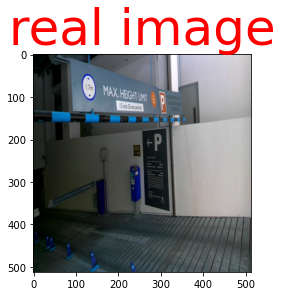

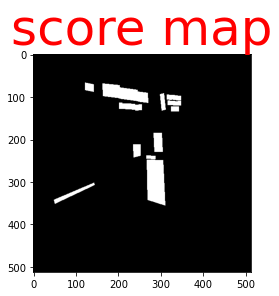

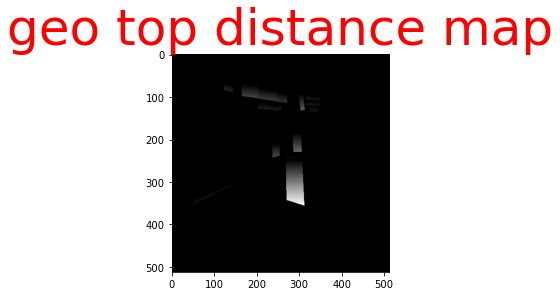

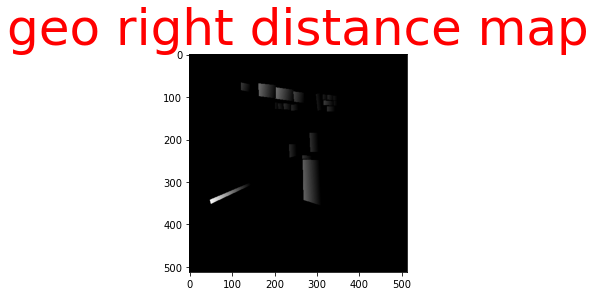

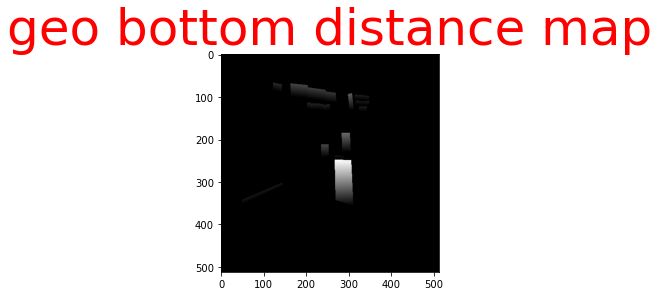

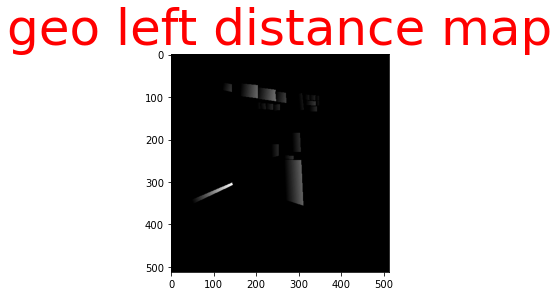

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


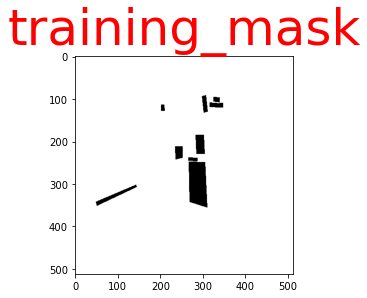

(1, 512, 512, 7)
(512, 512)


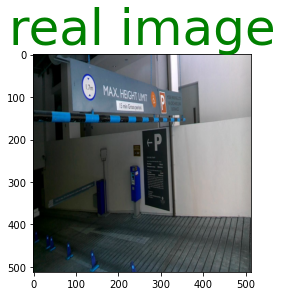

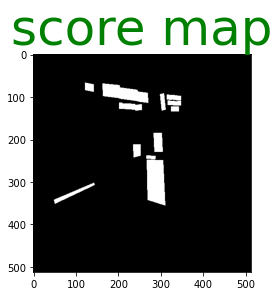

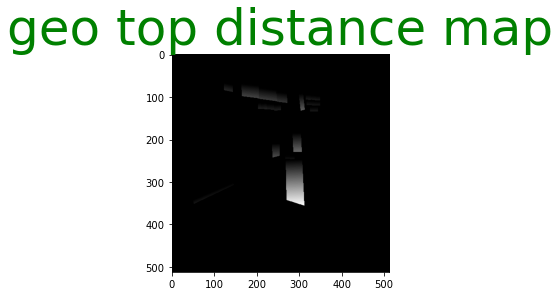

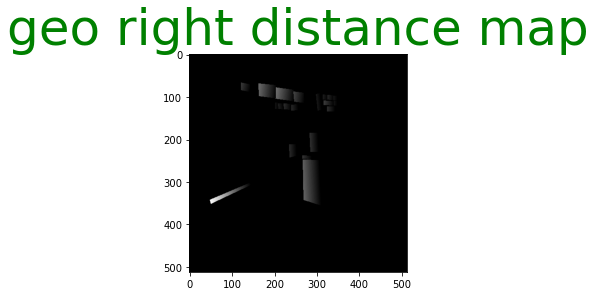

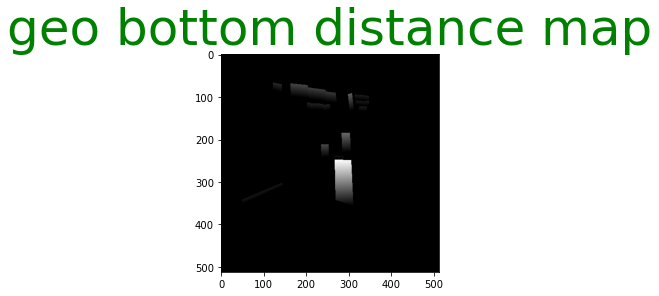

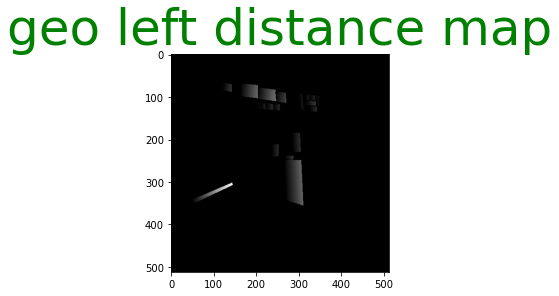

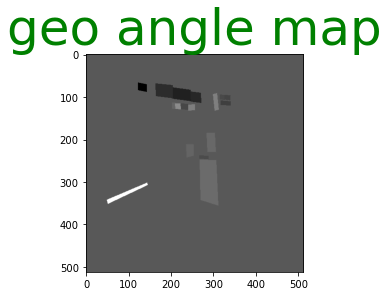

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


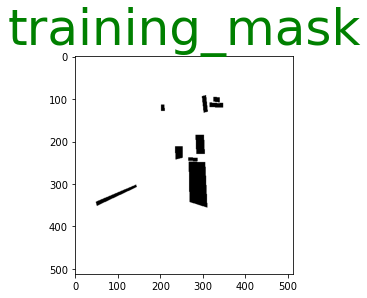

In [38]:
test()

iter:  0


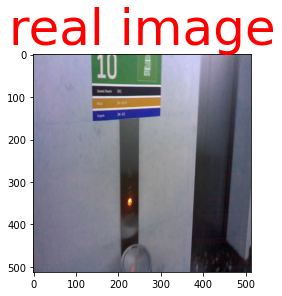

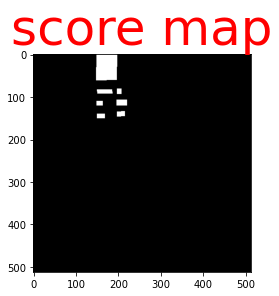

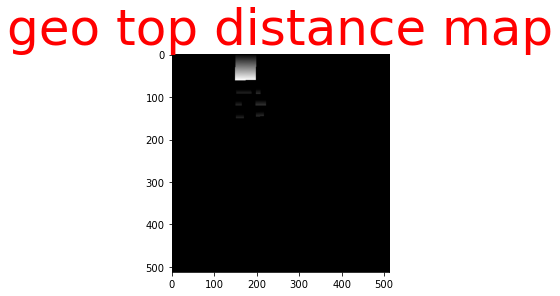

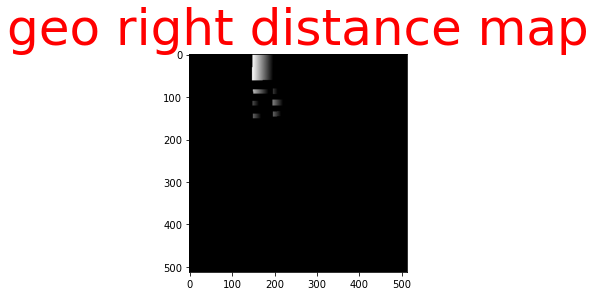

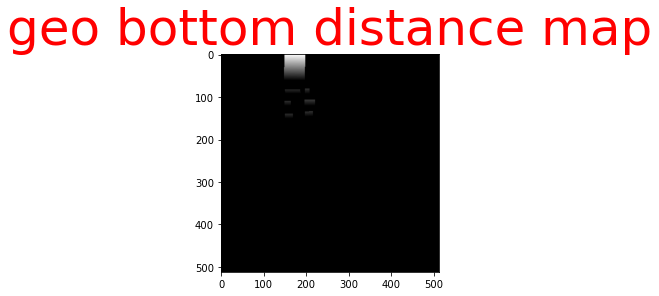

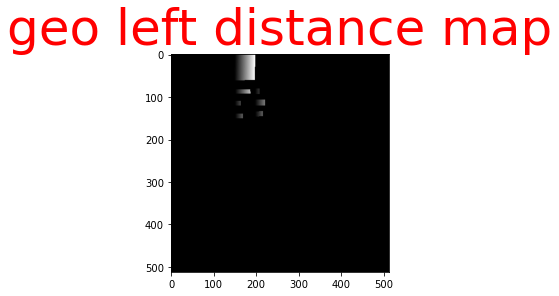

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


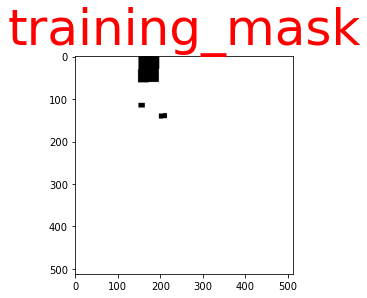

(1, 512, 512, 7)
(512, 512)


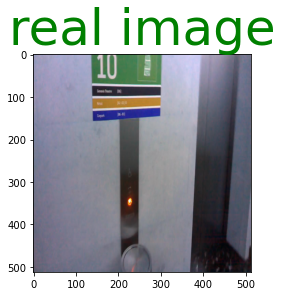

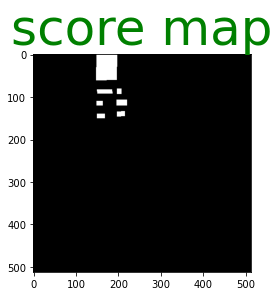

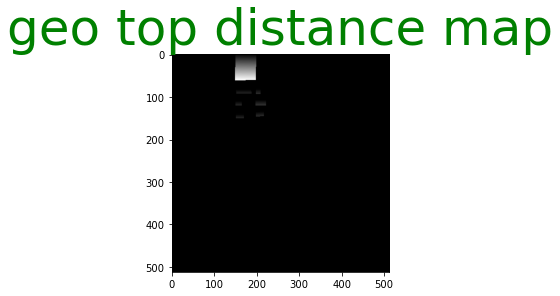

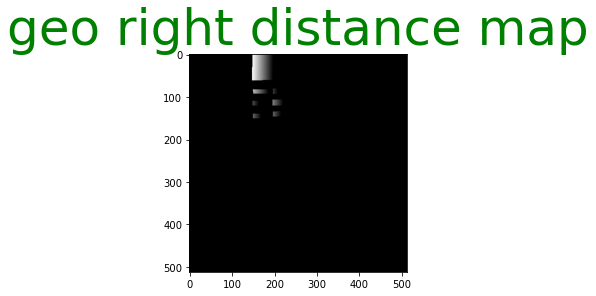

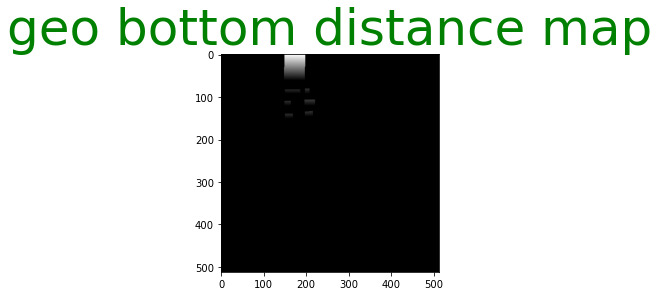

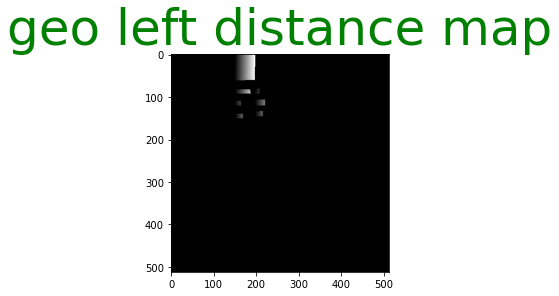

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


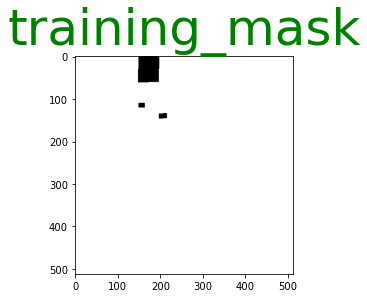

In [113]:
test()

iter:  0
(512, 512)


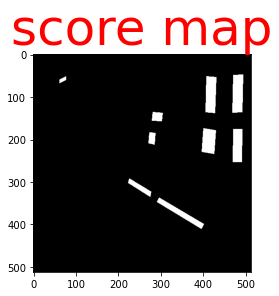

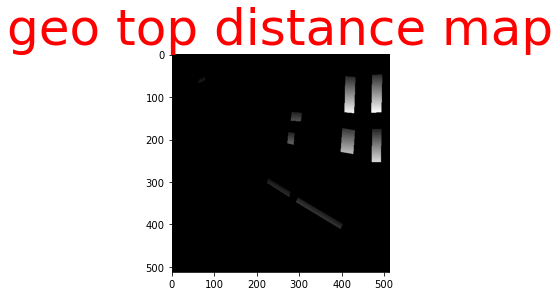

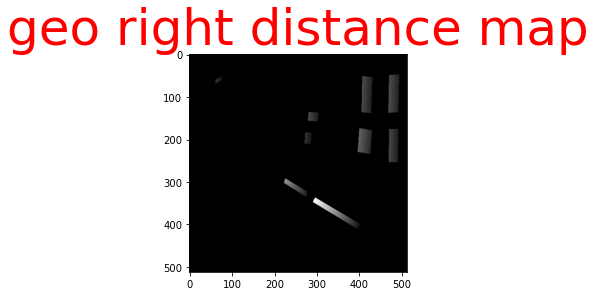

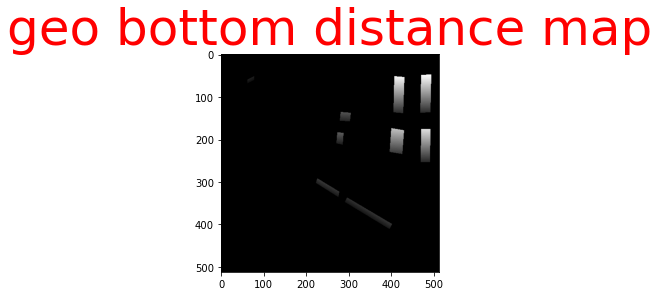

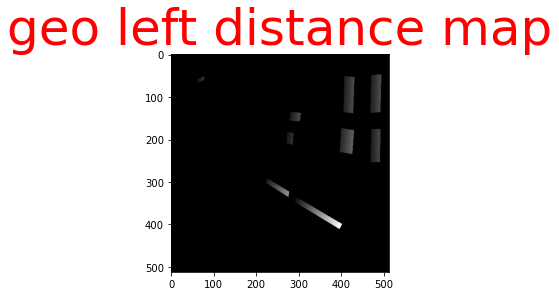

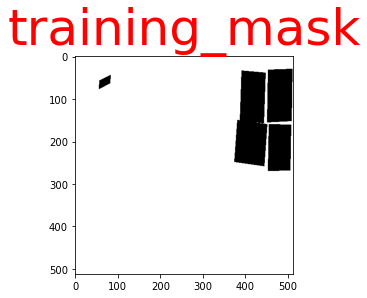

In [134]:
test()

##  using tf.data.dataset for input pipelines

In [22]:
def generator_for_tf_data(input_images_dir, input_gt_dir, input_size=512, batch_size=12, random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2]),):
    # data_loader = SynthTextLoader()
    # data_loader = ICDARLoader(edition='13', shuffle=True)
    # image_list = np.array(data_loader.get_images(FLAGS.training_data_dir))
    #print(input_images_dir)
    input_images_dir=input_images_dir.decode('utf-8')
    input_gt_dir=input_gt_dir.decode('utf-8')
    #input_gt_dir=str(input_gt_dir)
    #print(input_images_dir)
    
    image_list = np.array([i for i in os.listdir(input_images_dir)])
    # print('{} training images in {} '.format(image_list.shape[0], FLAGS.training_data_dir))
    index = np.arange(0, image_list.shape[0])
    # while True:
    np.random.shuffle(index)
    batch_images = []
    batch_image_fns = []
    batch_score_maps = []
    batch_geo_maps = []
    batch_training_masks = []

    batch_text_polyses = []
    batch_text_tagses = []
    batch_boxes_masks = []

    batch_text_labels = []
    count = 0
    for i in index:
        # try:
        im_fn = image_list[i]
        # print(im_fn)
        # if im_fn.split(".")[0][-1] == '0' or im_fn.split(".")[0][-1] == '2':
        #     continue
        # print(os.path.join(input_images_dir, im_fn))
        im = cv2.imread(os.path.join(input_images_dir, im_fn),cv2.IMREAD_UNCHANGED)
        h, w, _ = im.shape
        #print('h, w, _ = im.shape',h, w, _)
        file_name = "gt_" + im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt').split('/')[-1]
        #print(file_name)
        # file_name = im_fn.replace(im_fn.split('.')[1], 'txt') # using for synthtext
        # txt_fn = os.path.join(FLAGS.training_gt_data_dir, file_name)
        txt_fn = os.path.join(input_gt_dir, file_name)
        if not os.path.exists(txt_fn):
            #print('text file {} does not exists'.format(txt_fn))
            continue
        #print(txt_fn)
        text_polys=[]
        text_tags=[]
        text_labels=[]
        with open(txt_fn, 'r') as f:
            reader = csv.reader(f)
            for line in reader:

                text_labels.append(line[-1])
                if line[-1]=='*' or line[-1]=='###':
                    text_tags.append(True)
                else:
                    text_tags.append(False)
                line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
                text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        # data_loader.load_annotation(txt_fn) # Change for load text transiption

        text_polys = np.array(text_polys, dtype=np.float32)
        text_tags = np.array(text_tags, dtype=np.bool)
        text_labels = np.array(text_labels,dtype=np.object)
        #print(text_polys)
        #print(text_tags)
        #print(text_labels)
        if text_polys.shape[0] == 0:
            continue
        #print('text_polys.shape',text_polys.shape)
        #print('text_tags.shape',text_tags.shape)
        #print('text_labels.shape',text_labels.shape)
        text_polys, text_tags, text_labels = check_and_validate_polys(text_polys, text_tags, text_labels, (h, w))
        
        if text_polys.shape[0] == 0:
            continue

        ############################# Data Augmentation ##############################
        # random scale this image
#         rd_scale = np.random.choice(random_scale)
#         im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
#         text_polys *= rd_scale

        # rotate image from [-10, 10]j
#         cv2.imshow("image", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#         angle = random.randint(-10, 10)
#         im, text_polys = rotate_image(im, text_polys, angle)
#         cv2.imshow("rotated image", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()


        # 600×600 random samples are cropped.
        # cv2.imshow("Resized images", im)
        #print('-------------------------------------------------------')
#         im, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
#         cv2.imshow("cropped image", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        # cv2.imshow("Resized image", im)

        # im, text_polys, text_tags, selected_poly = crop_area_fix(im, text_polys, text_tags, crop_size=(600, 600))
        #
#         text_labels = [text_labels[i] for i in selected_poly]
#         if text_polys.shape[0] == 0 or len(text_labels) == 0:
#             continue

        # pad the image to the training input size or the longer side of image
#         new_h, new_w, _ = im.shape
#         max_h_w_i = np.max([new_h, new_w, input_size])
#         im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
#         im_padded[:new_h, :new_w, :] = im.copy()
#         im = im_padded
        # resize the image to input size
        new_h, new_w, _ = im.shape
        resize_h = input_size
        resize_w = input_size
        im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
        resize_ratio_3_x = resize_w/float(new_w)
        resize_ratio_3_y = resize_h/float(new_h)
        text_polys[:, :, 0] *= resize_ratio_3_x
        text_polys[:, :, 1] *= resize_ratio_3_y
        new_h, new_w, _ = im.shape
        #print(im.shape)
        score_map, geo_map, training_mask, rectangles = generate_rbox((new_h, new_w), text_polys, text_tags)
        if type(score_map)!=np.ndarray:
                if score_map==None:
                    continue
#         print(score_map.shape)
#         plt.imshow(score_map, cmap="gray")
#         plt.title('score map',color='red',size=50)
#         plt.show() 
#         for i in geo_map[:,:,0]:
#             for j in i:
#                 if j!=0:
#                     print(j)
#         plt.imshow(geo_map[:,:,0], cmap="gray")
#         plt.title('geo top distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(geo_map[:,:,1], cmap="gray")
#         plt.title('geo right distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(geo_map[:,:,2], cmap="gray")
#         plt.title('geo bottom distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(geo_map[:,:,3], cmap="gray")
#         plt.title('geo left distance map',color='red',size=50)
#         plt.show()
        
#         plt.imshow(training_mask, cmap="gray")
#         plt.title('training_mask',color='red',size=50)
#         plt.show()
        # print(('----------------------------------------------------------------'))
        #print(score_map)
        ##print(geo_map)
        #print(training_mask)
        #print(rectangles)
        # cv2.polylines(im, [text_polys[0].astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
#         cv2.imshow("Resized imag", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

        mask = [not (word == [-1]) for word in text_labels]
        text_labels = list(compress(text_labels, mask))
        rectangles = list(compress(rectangles, mask))

        assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"

        if len(text_labels) == 0:
            continue

        boxes_mask = np.array([count] * len(rectangles))

        count += 1
#         print(geo_map[::4, ::4, :].shape)
        batch_images.append(im[:, :, ::-1].astype(np.float32))
        batch_image_fns.append(im_fn)
        batch_score_maps.append(score_map[:, :, np.newaxis].astype(np.float32))
        batch_geo_maps.append(geo_map[:, :, :].astype(np.float32))
        batch_training_masks.append(training_mask[:, :, np.newaxis].astype(np.float32))

        batch_text_polyses.append(rectangles)
        batch_boxes_masks.append(boxes_mask)
        batch_text_labels.extend(text_labels)
        batch_text_tagses.append(text_tags)
        # return

        if len(batch_images) == batch_size:
#             batch_text_polyses = np.concatenate(batch_text_polyses)
#             batch_text_tagses = np.concatenate(batch_text_tagses)
#             batch_transform_matrixes, batch_box_widths = get_project_matrix_and_width(batch_text_polyses, batch_text_tagses)
#             # TODO limit the batch size of recognition
#             batch_text_labels_sparse = sparse_tuple_from(np.array(batch_text_labels),dtype=np.str)

            # yield images, image_fns, score_maps, geo_maps, training_masks
            #print(np.array(batch_geo_maps).shape)
            yield (np.array(batch_images),np.concatenate([np.array(batch_score_maps), np.array(batch_geo_maps), np.array(batch_training_masks)],axis=3))
            batch_images = []
            batch_image_fns = []
            batch_score_maps = []
            batch_geo_maps = []
            batch_training_masks = []
            batch_text_polyses = []
            batch_text_tagses = []
            batch_boxes_masks = []
            batch_text_labels = []
            count = 0
        # except Exception as e:
        #     import traceback
        #     print(im_fn)
        #     traceback.print_exc()
        #     continue


In [145]:
dataset = tf.data.Dataset.from_generator(
     generator_for_tf_data,
     (tf.float64, tf.float64),
     args=(tf.constant('data/ch4_training_images/'),'data/ch4_training_localization_transcription_gt/',512,10))
dataset = dataset.cache()

## preparing data for recognition part

here we will reshape our all text images with same length and encode our labels for each image after that we can train our recognition model by giving images as input and encoded label as output.

In [21]:
# def crop_image_with_word(input_images_dir,input_gt_dir):
#     image_list = np.array([i for i in os.listdir(input_images_dir)])
#     # print('{} training images in {} '.format(image_list.shape[0], FLAGS.training_data_dir))
#     index = np.arange(0, image_list.shape[0])
#     # while True:
#     np.random.shuffle(index)
#     batch_images = []
    

#     batch_text_polyses = []
#     batch_text_tagses = []
    

#     batch_text_labels = []
#     count = 0
#     for i in index:
#         # try:
#         im_fn = image_list[i]
#         # print(im_fn)
#         # if im_fn.split(".")[0][-1] == '0' or im_fn.split(".")[0][-1] == '2':
#         #     continue
#         im = cv2.imread(os.path.join(input_images_dir, im_fn))
#         h, w, _ = im.shape
#         #print('h, w, _ = im.shape',h, w, _)
#         file_name = "gt_" + im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt').split('/')[-1]
#         #print(file_name)
#         # file_name = im_fn.replace(im_fn.split('.')[1], 'txt') # using for synthtext
#         # txt_fn = os.path.join(FLAGS.training_gt_data_dir, file_name)
#         txt_fn = os.path.join(input_gt_dir, file_name)
#         if not os.path.exists(txt_fn):
#             #print('text file {} does not exists'.format(txt_fn))
#             continue
#         #print(txt_fn)
#         text_polys=[]
#         text_tags=[]
#         text_labels=[]
#         with open(txt_fn, 'r') as f:
#             reader = csv.reader(f)
#             for line in reader:

#                 text_labels.append(line[-1])
#                 if line[-1]=='*' or line[-1]=='###':
#                     text_tags.append(True)
#                 else:
#                     text_tags.append(False)
#                 line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]
#                 x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
#                 text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
#         # data_loader.load_annotation(txt_fn) # Change for load text transiption

#         text_polys = np.array(text_polys, dtype=np.float32)
#         text_tags = np.array(text_tags, dtype=np.bool)
#         text_labels = np.array(text_labels,dtype=np.object)
        
#         for text_poly,labels,tags in zip(text_polys,text_labels,text_tags):
#             print(text_poly)
#             if tags==False and len(text_labels)>6:
#                 x1y1=text_poly[0]
#                 x2y2=text_poly[1]
#                 x3y3=text_poly[2]
#                 x4y4=text_poly[3]

#                 min_x=int(min(x1y1[0],x4y4[0]))
#                 max_x=int(max(x2y2[0],x3y3[0]))

#                 min_y=int(min(x1y1[1],x4y4[1]))
#                 max_y=int(max(x2y2[1],x3y3[1]))
#                 if max_y-min_y<=40 or (max_y-min_y) in list(range((max_x-min_x)-40,(max_x-min_x)+40)) or max_x-min_x<=110:
#                     continue
#                 print(max_x-min_x)
#                 print(max_y-min_y)

#                 im_word=im[min_y:max_y,min_x:max_x]
#                 print(im_word.shape)
#                 # break
#                 if (max_y-min_y)>(max_x-min_x)*2:
#                     im_word=np.rot90(im_word,axes=(1,0))
#                 cv2.imshow(labels, im_word)
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()
            
            
           

In [22]:
#crop_image_with_word(input_images_dir='data/ch4_training_images/', input_gt_dir='ch4_training_localization_transcription_gt/')

In [23]:
# im_word=cv2.imread('synth_data/1_ablutions_304.jpg')
# im_word=np.rot90(im_word,axes=(1,0))
# cv2.imshow('labels', im_word)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### generating text_images from given ICDAR data and adding it in a folder

In [24]:
def generator_text(df, batch_size=12, random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2]),):
    
    count = 1
    images_with_label=[]
    input_images_dir='data/ch4_training_word_images_gt/'
    for i in tqdm(df.values):
        # try:
        im_fn = i[0]
       
        
        im = cv2.imread(os.path.join(input_images_dir, im_fn))
        h, w, _ = im.shape
      
        text_polys=[]
        text_tags=[]
        text_labels=[]

        x1, y1, x2, y2, x3, y3, x4, y4 = list(i[1:9])
        text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        text_tags.append(False)
        text_labels.append(i[9].strip()[1:-1])
        

        text_polys = np.array(text_polys, dtype=np.float32)
        text_tags = np.array(text_tags, dtype=np.bool)
        text_labels = np.array(text_labels,dtype=np.object)
        
        if text_polys.shape[0] == 0:
            continue
        
        text_polys, text_tags, text_labels = check_and_validate_polys(text_polys, text_tags, text_labels, (h, w))

        
        
        rd_scale = np.random.choice(random_scale)
        im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
        text_polys *= rd_scale

        # rotate image from [-10, 10]j
        angle = random.randint(-10, 10)

        im, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
        cv2.imshow("Resized image", im)

       
        if len(selected_poly)==1:
            text_labels = [text_labels[i] for i in selected_poly]
            if text_polys.shape[0] == 0 or len(text_labels) == 0:
                continue

            resize_h = 15
            resize_w = 64
            im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
            cv2.imwrite('data\\word_images\\'+str(count)+'_'+text_labels[0]+'.png',im)
            images_with_label.append(['data/word_images/'+str(count)+'_'+text_labels[0]+'.png',text_labels[0]])
            count=count+1
        
    return images_with_label


In [25]:
def get_batch_text(num_workers, **kwargs):
    data = generator_text(**kwargs)
    return data

In [21]:
df1=pd.read_csv('data/ch4_training_word_images_gt/coords.txt',names=[0,1,2,3,4,5,6,7,8])

In [22]:
df2=pd.read_csv('data/ch4_training_word_images_gt/gt.txt',names=[0,1])

In [23]:
df3=pd.merge(df1,df2,on=0)

In [24]:
dg = get_batch_text(num_workers=1,df= df3, input_size=50, batch_size=1)


100%|█████████████████████████████████████████████████████████████████████████████| 4458/4458 [00:32<00:00, 138.17it/s]


In [29]:
final_df=pd.DataFrame(dg,columns=['path','labels'])

### generating images from synth data and saving it in same folder

In [31]:
def generator_text_img_from_synth(directory):
    
    count = 4416
    images_with_label=[]
    input_images_dir=os.listdir(directory)
    for i in tqdm(input_images_dir):
        # try:
        #im_fn = i[0]
        # print(im_fn)
        # if im_fn.split(".")[0][-1] == '0' or im_fn.split(".")[0][-1] == '2':
        #     continue
        #print(i)
        im = cv2.imread(os.path.join(directory, i))
        text_label=i.split('.')[0].split('_')[1]
        #print(text_label)
        resize_h = 15
        resize_w = 64
        im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
#         cv2.imshow("Resized imag", im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        cv2.imwrite('data\\word_images\\'+str(count)+'_'+text_label+'.png',im)
        images_with_label.append(['data/word_images/'+str(count)+'_'+text_label+'.png',text_label])
        count=count+1
        #break
        
    return images_with_label

In [32]:
image_list_synth=generator_text_img_from_synth('data/synth_data/')

100%|██████████████████████████████████████████████████████████████████████████| 149734/149734 [35:45<00:00, 69.77it/s]


In [47]:
#dg.extend(image_list_synth)

In [14]:
image_and_labels=[]
for i in os.listdir('data/word_images/'):
    if i[-1:-5:-1]=='gnp.':
        if i.split('.')[0].split('_')[1].isalnum():
            image_and_labels.append(['data/word_images/'+i,i.split('.')[0].split('_')[1]])

In [15]:
len(image_and_labels)

153816

In [16]:
final_df=pd.DataFrame(image_and_labels,columns=['path','labels'])

In [17]:
final_df.to_csv('data/final.csv',index=False)

In [159]:
final_df=pd.read_csv('data/final.csv')

In [160]:
X=final_df['path']
y=final_df['labels'].apply(lambda x:str(x))

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### encoding labels for training recognition network

In [162]:
tk=Tokenizer(char_level=True)
tk.fit_on_texts(y_train.values)

In [163]:
y_train_text=tk.texts_to_sequences(y_train.values)
y_test_text=tk.texts_to_sequences(y_test.values)

In [164]:
lenngths=[len(i) for i in y_train_text]

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

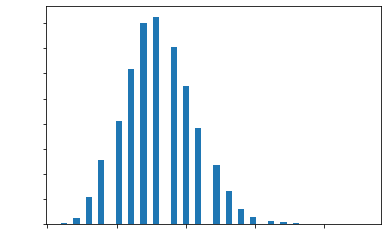

In [165]:
# fig=plt.figure()
# fig.x
plt.hist(lenngths,bins=50)
plt.xticks(color='white')
plt.yticks(color='white')

In [166]:
y_train_text=pad_sequences(y_train_text,maxlen=15,padding='post')
y_test_text=pad_sequences(y_test_text,maxlen=15,padding='post')

In [167]:
def data_generator_for_recognition(x_data,y_data,batch_size=16):
    batch=0
    images=[]
    labels=[]
    for i,j in zip(x_data,y_data):
        im=cv2.imread(i)
        images.append(im)
        labels.append(j)
        batch+=1
        if batch==batch_size:
            yield np.array(images,dtype=np.float64),np.array(labels,dtype=float64)
            
            images=[]
            labels=[]
            batch=0
        
        
    

In [17]:
gen=data_generator_for_recognition(X_train.values,y_train_text,batch_size=1)

In [159]:
for iter in range(1):
        print("iter: ", iter)
        data = next(gen)
        print(data)

iter:  0
(array([[[[18, 18, 18],
         [18, 18, 18],
         [18, 18, 18],
         ...,
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 9,  9,  9]],

        [[18, 18, 18],
         [19, 19, 19],
         [17, 17, 17],
         ...,
         [ 9,  9,  9],
         [ 7,  7,  7],
         [ 8,  8,  8]],

        [[18, 18, 18],
         [18, 18, 18],
         [20, 20, 20],
         ...,
         [ 9,  9,  9],
         [ 8,  8,  8],
         [ 8,  8,  8]],

        ...,

        [[17, 17, 17],
         [18, 18, 18],
         [19, 19, 19],
         ...,
         [ 5,  5,  5],
         [ 5,  5,  5],
         [ 5,  5,  5]],

        [[19, 19, 19],
         [18, 18, 18],
         [18, 18, 18],
         ...,
         [ 5,  5,  5],
         [ 4,  4,  4],
         [ 5,  5,  5]],

        [[17, 17, 17],
         [17, 17, 17],
         [18, 18, 18],
         ...,
         [ 5,  5,  5],
         [ 5,  5,  5],
         [ 6,  6,  6]]]], dtype=uint8), array([[16, 12, 15,  4,  6,  2,  0,  

## generating recognition input from tf.data api

In [168]:
def data_generator_for_recognition_from_tfdata(x_data,y_data,batch_size=16):
    batch=0
    c=0
    images=[]
    labels=[]
    for i,j in zip(x_data,y_data):
        i=i.decode('utf-8')
#         print(c)
        im=cv2.imread(i)

        images.append(im)
        labels.append(j)
        batch=batch+1
        if batch==batch_size:
            #print(np.array(images).shape)
#             if np.array(images).shape==(batch_size,15,64):
            yield np.array(images,dtype=np.float32),np.array(labels,dtype=np.float32)
            
            images=[]
            labels=[]
            batch=0

In [138]:
dataset_rec = tf.data.Dataset.from_generator(
     data_generator_for_recognition_from_tfdata,
     (tf.float64, tf.float64),
     args=(X_train.values,y_train_text,5))
dataset_rec = dataset_rec.cache()

## text detection model

In [23]:
input_sizes=512

In [24]:
#input_ = Input(shape=(128, 128,3))

resnet=tf.keras.applications.ResNet50(input_shape=(input_sizes,input_sizes,3),include_top=False,weights='imagenet')
# vgg16_1=vgg16(input_)
# tf.keras.backend.clear_session()
resnet.trainable=False

In [58]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [59]:
resnet.layers[0].input

<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>

In [60]:
resnet.layers[3].name

'conv1_bn'

In [25]:
f1,f2,f3,f4=None,None,None,None
for layer in resnet.layers:
    layer.trainable=False
    # print(layer.name)
    if layer.name=='pool1_pool':
        f1=layer.output
    if layer.name=='conv3_block1_1_conv':
        f2=layer.output
    if layer.name=='conv4_block1_1_conv':
        f3=layer.output
    if layer.name=='conv5_block3_2_conv':
        f4=layer.output
#     if layer.name=='block5_pool':
#         f5=layer.output

In [26]:
class feature_merging_branch(tf.keras.layers.Layer):
    def __init__(self,name='f_m_b',kernel=128,**kwargs):
        super().__init__(name)
        self.l_name=name
        self.kernel=kernel
    def build(self,input_shape1):
        print(input_shape1,'input shape1')
        self.conv1=Conv2D(self.kernel,1,padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.conv2=Conv2D(self.kernel,3,padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.bn1=BatchNormalization()
        self.bn2=BatchNormalization()

    def call(self,input_1):

        conv1=self.conv1(input_1)
        bn1=self.bn1(conv1)
        act1=Activation('relu')(bn1)
        conv2=self.conv2(act1)
        bn2=self.bn2(conv2)
        act2=Activation('relu')(bn2)
        #onv2=self.bn(conv2)
        return act2
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'name': self.l_name,
            'kernel': self.kernel,
            })
        return config

In [27]:
f3.shape

TensorShape([None, 32, 32, 256])

In [28]:
f4.shape

TensorShape([None, 16, 16, 512])

In [37]:
up1 = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)(f4)
print(up1)
con1 = concatenate([f3,up1],axis=3)
print(con1)
fmb1=feature_merging_branch(name='fmb1',kernel=128)(con1)
print(fmb1.shape)
up2 = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)(fmb1)
print(up2)
con2 = concatenate([f2,up2],axis=3)
fmb2=feature_merging_branch(name='fmb2',kernel=64)(con2)

up3 = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)(fmb2)
print(up3)
con3 = concatenate([f1,up3],axis=3)
print(con3,'con3')
fmb3 = feature_merging_branch(name='fmb3',kernel=32)(con3)
# fmb4=feature_merging_branch(name='fmb4')(fmb3,f1)
print(fmb3.shape)

up4=UpSampling2D(2,interpolation='bilinear',data_format='channels_last')(fmb3)
conv1=Conv2D(32,3,padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-5))(up4)
bn1=BatchNormalization()(conv1)
act1=Activation('relu')(bn1)

up5=UpSampling2D(2,interpolation='bilinear',data_format='channels_last')(act1)
conv2=Conv2D(64,3,padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-5))(up5)
bn2=BatchNormalization()(conv2)
act2=Activation('relu')(bn2)

score_map=Conv2D(1,1,activation='sigmoid')(act2)

geo_map=Conv2D(4,1,activation='sigmoid')(act2)*512

# geo_map=BatchNormalization()(geo_map)

angles=(Conv2D(1,1,activation='sigmoid')(act2)-0.5)*np.pi/2

# angles=BatchNormalization()(angles)

output=concatenate([score_map,geo_map,angles],axis=3)
detector=Model(resnet.input,output,name='detector')

Tensor("up_sampling2d_5/Identity:0", shape=(None, 32, 32, 512), dtype=float32)
Tensor("concatenate_4/Identity:0", shape=(None, 32, 32, 768), dtype=float32)
(None, 32, 32, 768) input shape1
(None, 32, 32, 128)
Tensor("up_sampling2d_6/Identity:0", shape=(None, 64, 64, 128), dtype=float32)
(None, 64, 64, 256) input shape1
Tensor("up_sampling2d_7/Identity:0", shape=(None, 128, 128, 64), dtype=float32)
Tensor("concatenate_6/Identity:0", shape=(None, 128, 128, 128), dtype=float32) con3
(None, 128, 128, 128) input shape1
(None, 128, 128, 32)


In [60]:
detector.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

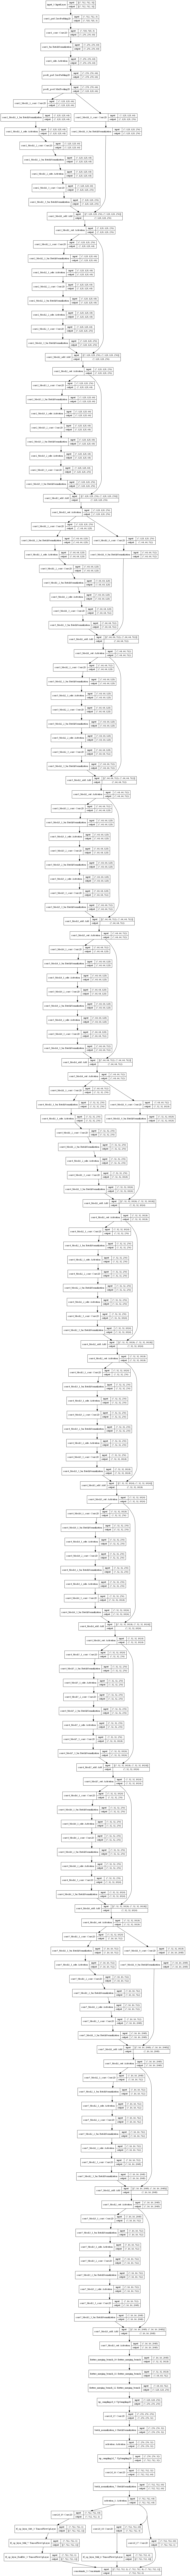

In [62]:
plot_model(detector,show_shapes=True)

In [38]:
# computing dice loss
def dice_loss(y_true_class,y_pred_class,training_mask):
    # we  are taking intersecting pixels ignoring pixels in training masks
    intersection=tf.reduce_sum(y_true_class*y_pred_class*training_mask)
    # calculating sum of total pixels where pixel is text
    union=tf.reduce_sum(y_true_class*training_mask)+tf.reduce_sum(y_pred_class*training_mask)
    eps=10**-7
    # calculating dice loss
    dice_loss_=1.0-(2*(intersection/(union+eps)))
    return dice_loss_

In [39]:
# detection loss
class detection_loss(tf.keras.losses.Loss):
    def __init__(self,reduction=tf.keras.losses.Reduction.AUTO, name=None):
        super().__init__(reduction=reduction, name=name)
    def call(self,y_true,y_pred):
        y_true_score=y_true[:,:,:,0]
        y_pred_score=y_pred[:,:,:,0]
        y_true_geo=y_true[:,:,:,1:6]
        y_pred_geo=y_pred[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]
        loss_for_score=dice_loss(y_true_score,y_pred_score,training_mask)
        #print(loss_for_score.shape)
        loss_for_score*=0.01
        # print(tf.math.equal(tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)[0],45))
        d_t_gt, d_r_gt, d_b_gt, d_l_gt, angle_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
        d_t_pd, d_r_pd, d_b_pd, d_l_pd, angle_pd = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)
        # calculating area regarding each pixels with the help of hight and width
        area_pred= (d_t_pd+d_b_pd)*(d_r_pd+d_l_pd)
        # calculating area of original text area
        area_real= (d_t_gt+d_b_gt)*(d_r_gt+d_l_gt)
        # calculating intersected rectangle width
        width_intersected_rectangle=tf.minimum(d_r_gt,d_r_pd) + tf.minimum(d_l_gt,d_l_pd)
        # calculating intersected rectangle height
        height_intersected_rectangle=tf.minimum(d_t_gt,d_t_pd) + tf.minimum(d_b_gt,d_b_pd)
        # intersected area by multiplying intersected height snd intersected width
        intersected_area=width_intersected_rectangle*height_intersected_rectangle
        # total area which belongs to both actual text and the predicted text
        union_area=area_pred+area_real-intersected_area
        # calculating iou
        loss_iou=-tf.math.log((intersected_area+1)/(union_area+1))
        # calculating angle loss
        angle_loss=1-tf.cos(angle_pd-angle_gt)
        final_loss= (loss_iou)+(20*angle_loss)
        #print(final_loss.shape)
        final_loss=tf.squeeze(final_loss,axis=3)
        return 100*(tf.reduce_mean(final_loss*y_true_score*training_mask)+(loss_for_score))
            

        
        

In [40]:
detector.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),loss=detection_loss())

In [41]:
dataset = tf.data.Dataset.from_generator(
     generator_for_tf_data,
     (tf.float64, tf.float64),
    ((None,input_sizes,input_sizes,3),(None,input_sizes,input_sizes,7)),
     args=(tf.constant('C:/Users/vishw/applied ai course case studies/data/ch4_training_images/'),'C:/Users/vishw/applied ai course case studies/data/ch4_training_localization_transcription_gt/',input_sizes,1))
dataset = dataset.cache()

In [42]:
dataset_test = tf.data.Dataset.from_generator(
     generator_for_tf_data,
     (tf.float64, tf.float64),
    ((None,input_sizes,input_sizes,3),(None,input_sizes,input_sizes,7)),
     args=(tf.constant('C:/Users/vishw/applied ai course case studies/data/ch4_test_images/'),'C:/Users/vishw/applied ai course case studies/data/Challenge4_Test_Task1_GT/',input_sizes,1))
dataset_test = dataset_test.cache()

In [43]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_logs',write_images=True,histogram_freq=1,write_graph=False)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
modelchkpt=tf.keras.callbacks.ModelCheckpoint('detector_model.h5',save_best_only=True,mode='min',monitor='loss')
callbacks=[tensorboard,early_stop,modelchkpt]

In [44]:
detector.fit(dataset.repeat(),epochs=50,steps_per_epoch=1300//1,validation_data=dataset_test,validation_steps=200//1,callbacks=callbacks)

Epoch 1/50
 305/1300 [======>.......................] - ETA: 22:56 - loss: 5.4579

C:\Users\vishw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in float_scalars
  """


1300/1300 [==============================] - 1969s 2s/step - loss: 4.2306 - val_loss: 3.4951
Epoch 2/50
1300/1300 [==============================] - 494s 380ms/step - loss: 3.0552 - val_loss: 3.1483
Epoch 3/50
1300/1300 [==============================] - 477s 367ms/step - loss: 2.7011 - val_loss: 2.9145
Epoch 4/50
1300/1300 [==============================] - 473s 364ms/step - loss: 2.4535 - val_loss: 2.9607
Epoch 5/50
1300/1300 [==============================] - 467s 359ms/step - loss: 2.2452 - val_loss: 2.8423
Epoch 6/50
1300/1300 [==============================] - 479s 369ms/step - loss: 2.0660 - val_loss: 2.6661
Epoch 7/50
1300/1300 [==============================] - 468s 360ms/step - loss: 1.9732 - val_loss: 2.5673
Epoch 8/50
1300/1300 [==============================] - 502s 386ms/step - loss: 1.8366 - val_loss: 2.5535
Epoch 9/50
1300/1300 [==============================] - 492s 379ms/step - loss: 1.7786 - val_loss: 2.4942
Epoch 10/50
1300/1300 [==============================] - 49

In [45]:
detector.fit(dataset.repeat(),epochs=50,steps_per_epoch=1300//1,validation_data=dataset_test,validation_steps=200//1,callbacks=callbacks)

Epoch 1/50
1300/1300 [==============================] - ETA: 0s - loss: 0.8221

C:\Users\vishw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in float_scalars
  """


1300/1300 [==============================] - 505s 388ms/step - loss: 0.8221 - val_loss: 2.5215
Epoch 2/50
1300/1300 [==============================] - 529s 407ms/step - loss: 0.8029 - val_loss: 2.6283
Epoch 3/50
1300/1300 [==============================] - 568s 437ms/step - loss: 0.7926 - val_loss: 2.5857
Epoch 4/50
1300/1300 [==============================] - 513s 394ms/step - loss: 0.7818 - val_loss: 2.6273
Epoch 5/50
1300/1300 [==============================] - 514s 396ms/step - loss: 0.7778 - val_loss: 2.6640
Epoch 6/50
1300/1300 [==============================] - 520s 400ms/step - loss: 0.7745 - val_loss: 2.6430
Epoch 7/50
1300/1300 [==============================] - 546s 420ms/step - loss: 0.7825 - val_loss: 2.5921
Epoch 8/50
1300/1300 [==============================] - 587s 452ms/step - loss: 0.7617 - val_loss: 2.4914
Epoch 9/50
1300/1300 [==============================] - 510s 393ms/step - loss: 0.7611 - val_loss: 2.5457
Epoch 10/50
1300/1300 [==============================] - 

In [46]:
detector.fit(dataset.repeat(),epochs=50,steps_per_epoch=1300//1,validation_data=dataset_test,validation_steps=200//1,callbacks=callbacks)

Epoch 1/50
1300/1300 [==============================] - ETA: 0s - loss: 0.6095

C:\Users\vishw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in float_scalars
  """


1300/1300 [==============================] - 518s 398ms/step - loss: 0.6095 - val_loss: 2.5964
Epoch 2/50
1300/1300 [==============================] - 564s 434ms/step - loss: 0.5961 - val_loss: 2.5717
Epoch 3/50
1300/1300 [==============================] - 519s 400ms/step - loss: 0.5943 - val_loss: 2.5674
Epoch 4/50
1300/1300 [==============================] - 521s 401ms/step - loss: 0.6009 - val_loss: 2.5891
Epoch 5/50
1300/1300 [==============================] - 550s 423ms/step - loss: 0.5973 - val_loss: 2.6241
Epoch 6/50
1300/1300 [==============================] - 636s 489ms/step - loss: 0.5930 - val_loss: 2.6579
Epoch 7/50
1300/1300 [==============================] - 574s 441ms/step - loss: 0.5858 - val_loss: 2.6954
Epoch 8/50
1300/1300 [==============================] - 546s 420ms/step - loss: 0.5858 - val_loss: 2.6468
Epoch 9/50
1300/1300 [==============================] - 552s 425ms/step - loss: 0.5849 - val_loss: 2.6010
Epoch 10/50
1300/1300 [==============================] - 

In [47]:
detector.fit(dataset.repeat(),epochs=50,steps_per_epoch=1300//1,validation_data=dataset_test,validation_steps=200//1,callbacks=callbacks)

Epoch 1/50
1300/1300 [==============================] - ETA: 0s - loss: 0.5690

C:\Users\vishw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in float_scalars
  """


1300/1300 [==============================] - 533s 410ms/step - loss: 0.5690 - val_loss: 2.6324
Epoch 2/50
1300/1300 [==============================] - 557s 428ms/step - loss: 0.5525 - val_loss: 2.5476
Epoch 3/50
1300/1300 [==============================] - 530s 408ms/step - loss: 0.5557 - val_loss: 2.5440
Epoch 4/50
1300/1300 [==============================] - 528s 406ms/step - loss: 0.5481 - val_loss: 2.6545
Epoch 5/50
1300/1300 [==============================] - 558s 429ms/step - loss: 0.5446 - val_loss: 2.5308
Epoch 6/50
1300/1300 [==============================] - 538s 414ms/step - loss: 0.5355 - val_loss: 2.6284
Epoch 7/50
1300/1300 [==============================] - 539s 415ms/step - loss: 0.5407 - val_loss: 2.7895
Epoch 8/50
1300/1300 [==============================] - 584s 449ms/step - loss: 0.5423 - val_loss: 2.7084
Epoch 9/50
1300/1300 [==============================] - 563s 433ms/step - loss: 0.5332 - val_loss: 2.7369
Epoch 10/50
1300/1300 [==============================] - 

KeyboardInterrupt: 

In [48]:
detector.save('detector_model.h5')

# recognition model

In [180]:
inputs = tf.keras.layers.Input(name='input', shape=(15,64,3), dtype='float32')  

conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
bn1 = tf.keras.layers.BatchNormalization()(conv1)
act1 = tf.keras.layers.Activation('relu')(bn1)
maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max1')(act1)  

conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(maxpool1)  
bn2 = tf.keras.layers.BatchNormalization()(conv2)
act2 = tf.keras.layers.Activation('relu')(bn2)
maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max2')(act2)  

conv3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(maxpool2)  
bn3 = tf.keras.layers.BatchNormalization()(conv3)
act3 = tf.keras.layers.Activation('relu')(bn3)
conv4 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(act3)  
bn4 = tf.keras.layers.BatchNormalization()(conv4)
act4 = tf.keras.layers.Activation('relu')(bn4)
maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max3')(act4)  

conv5 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(maxpool3)  
bn5 = tf.keras.layers.BatchNormalization()(conv5)
act5 = tf.keras.layers.Activation('relu')(bn5)
conv6 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv6')(act5)   
bn6 = tf.keras.layers.BatchNormalization()(conv6)
act6 = tf.keras.layers.Activation('relu')(bn6)
print(act6.shape)


conv7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='con7')(act6) 
print(conv7.shape)
bn7 = tf.keras.layers.BatchNormalization()(conv7)
act7 = tf.keras.layers.Activation('relu')(bn7)
print(act7.shape)
re1 = tf.keras.layers.Reshape(target_shape=((64,64)), name='reshape')(act7)  
dense1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(re1) 

bidi1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,go_backwards=True))(dense1)
out1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,go_backwards=True))(bidi1)

dense2=tf.keras.layers.Dense(38)(out1)
out2=tf.keras.activations.softmax(dense2)
recognizer=tf.keras.models.Model(inputs,out2)

(None, 1, 64, 32)
(None, 1, 64, 64)
(None, 1, 64, 64)


In [181]:
def ctc_loss(y_true,y_pred):
  
  #https://stackoverflow.com/questions/64321779/how-to-use-tf-ctc-loss-with-variable-length-features-and-labels
  label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,np.ones((32,1),'int32')*64,label_length)


In [182]:

recognizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01
                                                 ,amsgrad=True),loss=ctc_loss)

In [176]:
dataset_rec = tf.data.Dataset.from_generator(
     data_generator_for_recognition_from_tfdata,
     (tf.float32, tf.float32),
     args=(X_train.values,y_train_text,32))
dataset_rec = dataset_rec.cache()

dataset_rec_test = tf.data.Dataset.from_generator(
     data_generator_for_recognition_from_tfdata,
     (tf.float32, tf.float32),
     args=(X_test.values,y_test_text,32))
dataset_rec_test = dataset_rec_test.cache()

In [177]:
len(X_test)

50760

In [183]:
# early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
modelchkpt=tf.keras.callbacks.ModelCheckpoint('best_recognizer.h5',save_best_only=True,mode='min',monitor='loss')
callbacks=[modelchkpt]

In [184]:
recognizer.fit(dataset_rec.repeat(),epochs=30,steps_per_epoch=len(X_train.values)//32,validation_data=dataset_rec_test,\
           validation_steps=50760//32,callbacks=callbacks)

Epoch 1/30
3220/3220 [==============================] - 1030s 320ms/step - loss: 20.1545 - val_loss: 11.0847
Epoch 2/30
3220/3220 [==============================] - 229s 71ms/step - loss: 7.5045 - val_loss: 7.9079
Epoch 3/30
3220/3220 [==============================] - 226s 70ms/step - loss: 5.9803 - val_loss: 6.0442
Epoch 4/30
3220/3220 [==============================] - 226s 70ms/step - loss: 7.3459 - val_loss: 25.2824
Epoch 5/30
3220/3220 [==============================] - 235s 73ms/step - loss: 23.0241 - val_loss: 16.7646
Epoch 6/30
3220/3220 [==============================] - 236s 73ms/step - loss: 9.5898 - val_loss: 7.4967
Epoch 7/30
3220/3220 [==============================] - 234s 73ms/step - loss: 6.7124 - val_loss: 6.4258
Epoch 8/30
3220/3220 [==============================] - 232s 72ms/step - loss: 6.1838 - val_loss: 5.9091
Epoch 9/30
3220/3220 [==============================] - 230s 71ms/step - loss: 5.8829 - val_loss: 5.9495
Epoch 10/30
3220/3220 [=========================

In [185]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [187]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [190]:
tokenizer.index_word

{1: 'e',
 2: 's',
 3: 'i',
 4: 'a',
 5: 'r',
 6: 'n',
 7: 't',
 8: 'o',
 9: 'l',
 10: 'c',
 11: 'd',
 12: 'u',
 13: 'g',
 14: 'p',
 15: 'm',
 16: 'h',
 17: 'b',
 18: 'y',
 19: 'f',
 20: 'v',
 21: 'k',
 22: 'w',
 23: 'z',
 24: 'x',
 25: 'j',
 26: 'q',
 27: '1',
 28: '0',
 29: '2',
 30: '5',
 31: '9',
 32: '4',
 33: '3',
 34: '8',
 35: '7',
 36: '6'}

In [191]:
X_test

103273      data/word_images/54478_promptness.png
121063     data/word_images/70500_merchandise.png
10890         data/word_images/109813_Halogen.png
105956        data/word_images/56894_brighter.png
61694        data/word_images/16849_unburdens.png
                           ...                   
141548       data/word_images/88953_quadruped.png
7926         data/word_images/107144_WAXINESS.png
146319          data/word_images/93251_Scuzzy.png
115472    data/word_images/65465_UNDERCLOTHES.png
50068           data/word_images/145105_Fixes.png
Name: path, Length: 50760, dtype: object